<a href="https://colab.research.google.com/github/tluxxx/CandleStickStudies/blob/main/01_candlestick_studies_predictive_power_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Candlestick Studies
# Pattern Detection and Analyses of Basic statistics
In this study we use functions of the well known TA-Lib-Library for identifying cnadlestick-patterns in stock data.  

Topics of the study are:
* frequency of occurance of candlestick-patterns in real stock data (S&P-500 index from 2000 to mid 2024)
* identification of the "most-active"-patterns (by highest number of occurences)
* analyses of the development of cummulated return over time (1-20 days after occcurence of a pattern)
* identification of the most profitable patterns
* analysing distribution of returns over time, test for normality
* comparison trading of most profitable candlestick patterns with trading, based on completely random entries; statistical tests of return distributions



The content of the notebook was published in the blog: https://medium.com/@Tobi_Lux/on-predictive-power-of-candlestick-patterns-in-stock-trading-an-experiment-d71dd92b4b27

* Revision: 2.0
* Author: Tobi Lux
* Update:  2026-02-06
* Adaptations:
    * change of installing TA-Lib from GitHub (instead for sourceforge) using the new "home" of Github: https://github.com/TA-Lib/ta-lib/tree/main
    * (mild) code adaptations (e.g. removing Multi-Index from downloaded yf-data)



# 1. Preparations

In [ ]:
# Install TA-Lib C library
!echo "⏳ Downloading TA-Lib..."
!wget -q http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz -O ta-lib-0.4.0-src.tar.gz

!echo "📦 Extracting..."
!tar -xzf ta-lib-0.4.0-src.tar.gz > /dev/null 2>&1

!echo "🔧 Configuring and building (this may take a minute)..."
!cd ta-lib && ./configure --prefix=/usr > /dev/null 2>&1 && make > /dev/null 2>&1 && make install > /dev/null 2>&1

!echo "🐍 Installing Python wrapper..."
!pip install -q ta-lib

!echo "✅ Done! Importing talib..."
print("✓ TA-Lib ready to use!")

⏳ Downloading TA-Lib...
📦 Extracting...
🔧 Configuring and building (this may take a minute)...
🐍 Installing Python wrapper...
✅ Done! Importing talib...
✓ TA-Lib ready to use!


In [ ]:
# import of data processing modules
import pandas as pd
import numpy as np
# import plotting modules
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
# import service modules
from datetime import date
import yfinance as yf
from tqdm import tqdm
import talib
# import statistics modules
import scipy.stats as st
import statsmodels.api as sm


In [ ]:
# download data
ticker = '^GSPC'
start_date, end_date = '2000-01-01', '2024-06-09'
df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = df[['Open','High','Low','Close']]
prices.columns = prices.columns.droplevel(1)
prices.tail(2)

Price,Open,High,Low,Close
Date,,,,
2024-06-06,5357.799805,5362.350098,5335.359863,5352.959961
2024-06-07,5343.810059,5375.080078,5331.330078,5346.990234


# 2. Overview and Basic Statistics of Occurences

In [ ]:
# identification of candle patterns
candle_names = talib.get_function_groups()['Pattern Recognition']

# defining the look_ahead-intervall and forming reduced price dataframe without last day_look_ahead-prices
days_look_ahead = 20
days = list(range(days_look_ahead + 1))
idx = prices.index[0:-(days_look_ahead + 1)]
prices_red = prices[prices.index.isin(idx)]

# counting of occurence of signals per candle pattern
cp = pd.DataFrame(index=prices_red.index)
signal_ = [-200, -100, 100, 200]
cp_stat = pd.DataFrame(columns=candle_names, index=signal_)

# nb of occurance of (candles, type)-combinations
for candle in candle_names:
  cp[candle] = getattr(talib, candle)(prices_red.Open, prices_red.High, prices_red.Low, prices_red.Close)
  for sg in signal_:
    cp_stat.loc[sg, candle] = cp[cp[candle] == sg][candle].count()

# occurence per pattern (bullish and bearish)
cp_stat_tr = cp_stat.T
cp_stat_tr['sum_bull'] = cp_stat_tr.iloc[:,2] + cp_stat_tr.iloc[:,3]
cp_stat_tr['sum_bear'] = cp_stat_tr.iloc[:,0] + cp_stat_tr.iloc[:,1]
cp_stat_tr['sum_all'] = cp_stat_tr['sum_bull'] + cp_stat_tr['sum_bear']
cp_stat_tr.sort_values('sum_all', inplace=True, ascending=False)

In [ ]:
# most active candle pattern
nb_occ = 100
most_active_bull = cp_stat_tr[cp_stat_tr['sum_bull'] > nb_occ].sort_values(by=['sum_bull'], ascending=False)
most_active_bear = cp_stat_tr[cp_stat_tr['sum_bear'] > nb_occ].sort_values(by=['sum_bear'], ascending=False)

In [ ]:
most_active_bull

,-200,-100,100,200,sum_bull,sum_bear,sum_all
CDLLONGLINE,0,580,841,0,841,580,1421
CDLBELTHOLD,0,687,822,0,822,687,1509
CDLDOJI,0,0,766,0,766,0,766
CDLLONGLEGGEDDOJI,0,0,766,0,766,0,766
CDLCLOSINGMARUBOZU,0,509,757,0,757,509,1266
CDLSPINNINGTOP,0,586,561,0,561,586,1147
CDLRICKSHAWMAN,0,0,560,0,560,0,560
CDLMARUBOZU,0,262,453,0,453,262,715
CDLSHORTLINE,0,235,436,0,436,235,671
CDLHIKKAKE,66,296,266,76,342,362,704


In [ ]:
most_active_bear

,-200,-100,100,200,sum_bull,sum_bear,sum_all
CDLBELTHOLD,0,687,822,0,822,687,1509
CDLSPINNINGTOP,0,586,561,0,561,586,1147
CDLLONGLINE,0,580,841,0,841,580,1421
CDLCLOSINGMARUBOZU,0,509,757,0,757,509,1266
CDLHIKKAKE,66,296,266,76,342,362,704
CDLHIGHWAVE,0,360,333,0,333,360,693
CDLMARUBOZU,0,262,453,0,453,262,715
CDLSHORTLINE,0,235,436,0,436,235,671
CDLHARAMI,0,200,165,0,165,200,365
CDLENGULFING,0,138,161,0,161,138,299


In [ ]:
# Bar-Chart showing the occurence of all patterns
main_title = 'number of occurences of all candlestick-pattterns'
sub_title = 'instrument: DAX,  duration: 2000-01-01 - 2024-06-09'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# plotting
fig = go.Figure()
for i in range(4):
  y_x = (cp_stat_tr.iloc[:, i].tolist())
  fig.add_trace(go.Bar(x=candle_names, y=y_x, name = cp_stat_tr.columns[i]))
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=600)
fig.update_layout(title=title, xaxis_title='candle-pattern', yaxis_title='# of occurences', legend_title="Signals from TA-LIB")
fig.update_layout(barmode='stack')
fig.update_xaxes(tickangle= -90)
fig.show()

In [ ]:
# definition of modes
modes = ['bullish','bearish']

In [ ]:
# Bar-Chart showing the most active patterns
main_title1 = f'number of occurences of most active bullish candlestick patterns'
main_title2 = f'number of occurences of most active bearish candlestick patterns'
sub_title = 'instrument: DAX,  duration: 2000-01-01 - 2024-06-09'
title1 = main_title1 + '<br><br><sup>' + sub_title + '</sup>'
title2 = main_title2 + '<br><br><sup>' + sub_title + '</sup>'
text_subtitles = [title1, title2]

# plotting
fig = make_subplots(rows=2, cols=1, subplot_titles = (text_subtitles))
for i, mode in enumerate(modes):
  if mode =='bullish':
    y_x = most_active_bull['sum_bull']
    x_x = most_active_bull.index
  elif mode =='bearish':
    y_x = most_active_bear['sum_bear']
    x_x = most_active_bear.index
  fig.add_trace(go.Bar(x=x_x, y=y_x, name=f'{modes[i]} candlestick patterns'), row=i+1, col=1)
  fig.update_yaxes(title_text='nb of occurence', row=i+1, col=1)

fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=1300)
fig.update_layout(legend_title="Signals from TA-LIB")
fig.update_xaxes(tickangle= -90)
fig.show()

# 3. calculation of development of positions

after detection of a candlestick pattern (and going LONG/Short) until closing the positions later (at + days_look_ahead), collecting the daily data for the development of the positons (price, return, cumulated return) in an sortable data frame

In [ ]:
# calculations of development of positions (=start at day of detection of a pattern (=occurence) until + days_look_ahead)
# going LONG/SHORT depending on the signal
# recording for each position from opening to close: price, returns and cumulated returns
# results collected in sortable dataframe

# preparation
traject_bull = pd.DataFrame()
traject_bear = pd.DataFrame()
trade_id_bull = 0
trade_id_bear = 0
indxs = prices.index.tolist()

# looking at bullish and bearish pattern separately
for mode in modes:
  # separate analyses for bullish and bearish candlestick  pattern
  if mode =='bullish':
    top_candle_names = most_active_bull.index.tolist()
  elif mode =='bearish':
    top_candle_names = most_active_bear.index.tolist()

  # looping through all bullish and bearish candlestick patterns separately
  for candle in tqdm(top_candle_names):
    # identification of dates and indexes of occurence of a certain "candlestick pattern"
    if mode == 'bullish':
      x_p = cp[cp[candle] > 0][candle]
    elif mode == 'bearish':
      x_p = cp[cp[candle] < 0][candle]
    idx = x_p.index.tolist()

    # looping through the identfied occurences
    for id  in idx:
      # for each occurence defining the ovservation intervall and collecting the corresponding prices
      id_start = indxs.index(id)
      id_x = indxs[id_start: id_start + days_look_ahead + 1]
      pr_x = prices[prices.index.isin(id_x)]['Close']
      if mode == 'bullish':
        trade_id_bull += 1
        rets_bull_x = pr_x.pct_change().fillna(0)              # positive return, since we are in a LONG positions
        cumrets_bull_x = (1 + rets_bull_x).cumprod()
        # transfering into a data-frame and connecting to the previous data
        dict_df =  {'pattern': [candle] * (days_look_ahead + 1),
                    'mode': ['bullish'] * (days_look_ahead + 1),
                    'pattern_id':[trade_id_bull] * (days_look_ahead + 1),
                    'date_id': id_x,
                    'day': days,
                    'close': pr_x.to_list(),
                    'rets':rets_bull_x.to_list(),
                    'cumrets':cumrets_bull_x.to_list()}
        tr_bull_x = pd.DataFrame(dict_df)
        traject_bull = pd.concat([traject_bull, tr_bull_x], axis=0)
      elif mode == 'bearish':
        trade_id_bear += 1
        rets_bear_x = - pr_x.pct_change().fillna(0)              # negative retun, since we are in a SHORT position
        cumrets_bear_x = (1 + rets_bear_x).cumprod()
        # transfering into a data-frame and connecting to the previous data
        dict_df =  {'pattern': [candle] * (days_look_ahead + 1),
                    'mode': ['bearish'] * (days_look_ahead + 1),
                    'pattern_id':[trade_id_bear] * (days_look_ahead + 1),
                    'date_id': id_x,
                    'day': days,
                    'close': pr_x.to_list(),
                    'rets':rets_bear_x.to_list(),
                    'cumrets':cumrets_bear_x.to_list()}
        tr_bear_x = pd.DataFrame(dict_df)
        traject_bear = pd.concat([traject_bear, tr_bear_x], axis=0)


100%|██████████| 11/11 [00:15<00:00,  1.36s/it]


# 4. Statistical Analyses

## 4.1. Development of positions over time
monitoring the development of the averaged cummulated return per day and per bullish or bearish candlestick pattern

In [ ]:
# tabulation of averaged cumulated returns for each bullish/bearish candlestick pattern and each day

# preparation
days_str = ['day+' + str(i).zfill(2) for i in range(len(days))]
results_bull_avg_day =pd.DataFrame()
results_bear_avg_day =pd.DataFrame()

# separate analyses per bullish or bearish candlestick pattern per day
for day in days:
  tr_bull = traject_bull[(traject_bull['day'] == day)].groupby(['pattern'])['cumrets'].mean()
  results_bull_avg_day = pd.concat([results_bull_avg_day, tr_bull], axis=1)
  tr_bear = traject_bear[(traject_bear['day'] == day)].groupby(['pattern'])['cumrets'].mean()
  results_bear_avg_day = pd.concat([results_bear_avg_day, tr_bear], axis=1)

# renaming columns
results_bull_avg_day.columns = days_str
results_bear_avg_day.columns = days_str

In [ ]:
# displaying the average position development for the top active bullish and bearish candlestick patterns

main_title1 = f'development of PnL (= cumulative returns) of most active bullish candlestick patterns'
main_title2 = f'development of PnL (= cumulative returns) of most active bearish candlestick patterns'
sub_title = 'instrument: DAX,  duration: 2000-01-01 - 2024-06-09'
title1 = main_title1 + '<br><br><sup>' + sub_title + '</sup>'
title2 = main_title2 + '<br><br><sup>' + sub_title + '</sup>'
text_subtitles = [title1, title2]

# plotting of cumulated returns per pattern and day as store in results_bull_avg_day and results_bear_avg_day
fig = make_subplots(rows=2, cols=1, subplot_titles = (text_subtitles))
for i in range(len(results_bull_avg_day)):
  y_x = results_bull_avg_day.iloc[i].tolist()
  fig.add_trace(go.Scatter(x=days_str, y=y_x, name=f'{results_bull_avg_day.index[i]} bullish'), row=1, col=1)
for i in range(len(results_bear_avg_day)):
  y_x = results_bear_avg_day.iloc[i].tolist()
  fig.add_trace(go.Scatter(x=days_str, y=y_x, name=f'{results_bear_avg_day.index[i]} bearish'), row=2, col=1)
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=900)
fig.update_xaxes(tickangle= -90)
fig.show()

## 4.2. identifying most profitable candlestick pattern
profitability is measured by cumulated returns at selected days

In [ ]:
# days for further analyses
days_analyzed = [1, 5, 10, 15, 20]

In [ ]:
# extraction of the top performers by analysing the cumrets at selected days

# preparation
top_bull_px = []
top_bear_px = []
selected_cols = []

# extration of data for the days to be analyzed
for day in days_analyzed:
  selected_cols.append('day+' + str(day).zfill(2))
results_bull_selected = results_bull_avg_day[selected_cols]
results_bear_selected = results_bear_avg_day[selected_cols]

# selection ot the top 3 pattern for each analyzed day and collecting the data in a list
for col in selected_cols:
  x_bull = results_bull_selected[col].sort_values(ascending=False).iloc[0:3]
  y_bull = x_bull.index.tolist()
  top_bull_px = top_bull_px + y_bull
  x_bear = results_bear_selected[col].sort_values(ascending=False).iloc[0:3]
  y_bear = x_bear.index.tolist()
  top_bear_px = top_bear_px + y_bear

# removal of duplication from the lists
top_bull_patterns = list(set(top_bull_px))
top_bear_patterns = list(set(top_bear_px))

# printing results
print(f'top profitable bullish candlestick patterns: {top_bull_patterns}')
print(f'top profitable bearish candlestick patterns: {top_bear_patterns}')

top profitable bullish candlestick patterns: ['CDLRICKSHAWMAN', 'CDLSPINNINGTOP', 'CDLHAMMER', 'CDLLONGLEGGEDDOJI', 'CDLHIGHWAVE', 'CDLHIKKAKE']
top profitable bearish candlestick patterns: ['CDLHANGINGMAN', 'CDLENGULFING', 'CDLSHORTLINE', 'CDLHARAMI', 'CDLHIKKAKE']


## 4.4 Development and Distributions of PnL of position (= cummulated returns) over time

In [ ]:
# selection of pattern and mode for detailed analyses
candle = top_bull_patterns[2]
mode = modes[0]

### 4.4.1 Development of PnL over time for a selected candlestick pattern and selected mode

In [ ]:
# development of distribution of PnL (= cumulated returns) for selected patterns over time - BOX-plot
main_title = f'development of PnL distribution of positions after occurence of {candle} in {mode} mode'
sub_title = f'instrument: DAX,  duration: 2000-01-01 - 2024-06-09 '
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# preparation
if mode == 'bullish':
  p_x = traject_bull[(traject_bull['pattern'] == candle)]
elif mode == 'bearish':
  p_x = traject_bear[(traject_bear['pattern'] == candle)]

# plotting
fig = px.box(p_x, x='day', y ='cumrets', points='all')
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=600)
fig.update_layout(title=title, xaxis_title='days after occurence of pattern', yaxis_title='# PnL of position', legend_title='candle pattern')
fig.update_xaxes(dtick=1, tickangle= -90)
fig.show()


### Excursus: verification of max-PnL and min-PnL

In [ ]:
# cross check for correctnes of minmal and maximal PnL-values
# filtering for selected candle pattern and removing current index, replacing by row-number as index
cr_candle = traject_bull[traject_bull['pattern'] == candle].reset_index()

# detecting of value and index of minimum PnL and maximum PnL
idxmax, valmax = cr_candle['cumrets'].agg(['idxmax', 'max'])
idxmin, valmin = cr_candle['cumrets'].agg(['idxmin', 'min'])
idxmax = int(idxmax)
idxmin = int(idxmin)

# Identification of pattern-ID  for extracting the relevant data
pattern_max = cr_candle.loc[idxmax, 'pattern_id']
date_max = cr_candle.loc[idxmax, 'date_id']
date_min = cr_candle.loc[idxmin, 'date_id']
pattern_min = cr_candle.loc[idxmin, 'pattern_id']

# printing
print(f'pattern: {candle}')
print(f'idx max: {idxmax}  date max: {date_max.date()}  PnL max: {valmax:.4f}  idx min {idxmin}  date min: {date_min.date()}  PnL min: {valmin:.4f}')
print(f'ID pattern_max: {pattern_max}  ID pattern_min: {pattern_min}')


pattern: CDLHAMMER
idx max: 187  date max: 2001-04-19  PnL max: 1.1218  idx min 501  date min: 2002-07-23  PnL min: 0.8194
ID pattern_max: 6646  ID pattern_min: 6661


In [ ]:
# crosscheck for trade around max PnL
cr_candle[cr_candle['pattern_id'] == pattern_max]

,index,pattern,mode,pattern_id,date_id,day,close,rets,cumrets
168,0,CDLHAMMER,bullish,6646,2001-03-22,0,1117.579956,0.000000,1.000000
169,1,CDLHAMMER,bullish,6646,2001-03-23,1,1139.829956,0.019909,1.019909
170,2,CDLHAMMER,bullish,6646,2001-03-26,2,1152.689941,0.011282,1.031416
171,3,CDLHAMMER,bullish,6646,2001-03-27,3,1182.170044,0.025575,1.057795
172,4,CDLHAMMER,bullish,6646,2001-03-28,4,1153.290039,-0.024430,1.031953
173,5,CDLHAMMER,bullish,6646,2001-03-29,5,1147.949951,-0.004630,1.027175
174,6,CDLHAMMER,bullish,6646,2001-03-30,6,1160.329956,0.010784,1.038252
175,7,CDLHAMMER,bullish,6646,2001-04-02,7,1145.869995,-0.012462,1.025314
176,8,CDLHAMMER,bullish,6646,2001-04-03,8,1106.459961,-0.034393,0.990050
177,9,CDLHAMMER,bullish,6646,2001-04-04,9,1103.250000,-0.002901,0.987178


In [ ]:
# crosscheck for trade around max PnL
cr_candle[cr_candle['pattern_id'] == pattern_min]

,index,pattern,mode,pattern_id,date_id,day,close,rets,cumrets
483,0,CDLHAMMER,bullish,6661,2002-06-26,0,973.530029,0.000000,1.000000
484,1,CDLHAMMER,bullish,6661,2002-06-27,1,990.640015,0.017575,1.017575
485,2,CDLHAMMER,bullish,6661,2002-06-28,2,989.820007,-0.000828,1.016733
486,3,CDLHAMMER,bullish,6661,2002-07-01,3,968.650024,-0.021388,0.994987
487,4,CDLHAMMER,bullish,6661,2002-07-02,4,948.090027,-0.021225,0.973868
488,5,CDLHAMMER,bullish,6661,2002-07-03,5,953.989990,0.006223,0.979929
489,6,CDLHAMMER,bullish,6661,2002-07-05,6,989.030029,0.036730,1.015921
490,7,CDLHAMMER,bullish,6661,2002-07-08,7,976.979980,-0.012184,1.003544
491,8,CDLHAMMER,bullish,6661,2002-07-09,8,952.830017,-0.024719,0.978737
492,9,CDLHAMMER,bullish,6661,2002-07-10,9,920.469971,-0.033962,0.945497


In [ ]:
# visualisation of location of max-PnL und min-Pnl after occurence of pattern
main_title = f'Prices and location of minimal/maximal values of PnL-development of positions after occurence of {candle} in {mode} mode'
sub_title = f'instrument: DAX,  duration: 2000-01-01 - 2024-06-09 '
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# dates for min and max PnL
date_pnl_max = date_max.date()
date_pnl_min = date_min.date()

# plotting
fig = go.Figure(data=[go.Candlestick(x=prices.index, open=prices['Open'], high=prices['High'], low=prices['Low'], close=prices['Close'])])
fig.add_vline(x=date_pnl_max, line_width=3, line_dash='dash', line_color='green')
fig.add_annotation(x=date_pnl_max, text=f'location of max-PnL = {valmax:.3f} at {date_pnl_max}')
fig.add_vline(x=date_pnl_min, line_width=3, line_dash='dash', line_color='blue')
fig.add_annotation(x=date_pnl_min, text=f'location of min-PnL = {valmin:.3f} at {date_pnl_min}')
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=600)
fig.update_layout(title=title, xaxis_title='date', yaxis_title='# prices')
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

### 4.4.2 distribution of PnL for a given candlestick patern and a given mode at certain days

In [ ]:
# distribution of PnL (=cumulated returns) over time

#preparations
days_str_analyzed = [f'day+' + str(i).zfill(2) for i in days_analyzed]

# plotting
fig = make_subplots(rows=1, cols=5, shared_yaxes=True, subplot_titles = (selected_cols))

for i, day in enumerate(days_analyzed):
  if mode == 'bullish':
    tx = traject_bull[(traject_bull['pattern'] == candle) & (traject_bull['day'] == day)]['cumrets']
  elif mode =='bearish':
    tx = traject_bear[(traject_bear['pattern'] == candle) & (traject_bear['day'] == day)]['cumrets']

  fig.add_trace(go.Histogram(y=tx.to_list(), name=days_str_analyzed[i], ybins=dict(start=0.75, end=1.25, size=0.01)), row=1, col=i+1)
  fig.add_hline(y=tx.mean(), line_dash="dot", row=1, col=i+1, annotation_text=f'mean: {tx.mean():.4f}', annotation_position="bottom right")

main_title = f'PnL-distribution after x-days of occurences of {candle} in {mode} mode, number of occurences: {len(tx)}'
title = main_title

fig.update_layout(template='plotly_dark', autosize=False, width=1600, height=600)
fig.update_layout(title=title, xaxis_title='# of occurences', yaxis_title='PnL of the day', legend_title='days after occurence')
fig.show()


## 4.5 Statistical Test for Normality

In [ ]:
# confidence-level for statistical tests and selection of day
alpha = 0.05
day = days_analyzed[4]    # [1, 5, 10, 15, 20]

 pattern:  CDLHAMMER   signal-type: bullish  number of occurences: 187   analyzed day:20   conf.-level:0.05

DAgostino & Pearson:              NOT Normal   p: 0.00038 statistic: 15.76546
Kolmogorov-Smirnov:               NOT Normal   p: 0.00100 statistic: 0.09155  
Jarque-Bera:                      NOT Normal   p: 0.00016 statistic: 17.52491
Lilliefors:                       NOT Normal   p: 0.00100 statistic: 0.09155
Shapiro-Wilk:                     NOT Normal   p: 0.00035 statistic: 0.09155     
Anderson–Darling:                 NOT Normal   statistic: 1.98302

 n: 187 mean: 1.0050 var: 0.002081  min: 0.8332  max: 1.1156 skewness: -0.6553 kurtosis: 0.7291



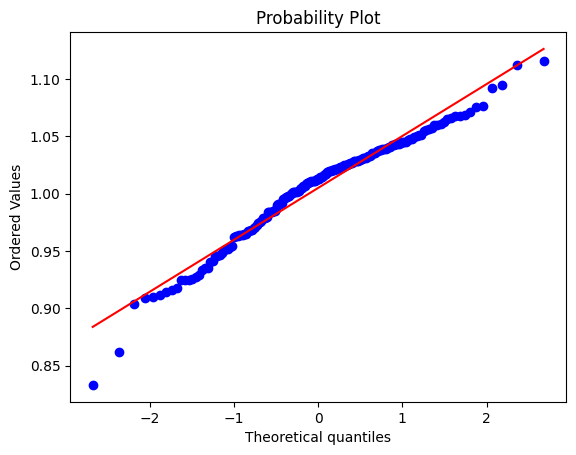

In [ ]:
# Check for normal distribution of PnL (= cumrets) for a given pattern, modus and day after occurence of pattern  (Extended Version)

# preparations
if mode == 'bullish':
  traject_1 = traject_bull[(traject_bull['pattern'] == candle) & (traject_bull['day'] == day)]['cumrets']
elif mode == 'bearish':
  traject_1 = traject_bear[(traject_bear['pattern'] == candle) & (traject_bear['day'] == day)]['cumrets']

data = traject_1.to_numpy()

print(f' pattern:  {candle}   signal-type: {mode}  number of occurences: {len(data)}   analyzed day:{day}   conf.-level:{alpha}')
print('')

# Perform D’Agostino-Pearson Test
statistic, pvalue = st.normaltest(data)
result = 'Normal' if pvalue > alpha else 'NOT Normal'
print(f'DAgostino & Pearson:             {result:>11s}   p: {pvalue:.5f} statistic: {statistic:.5f}')

# Perform Kolmogorov-Smirnov (-Lilliefors)-Test
ksstat, pvalue = sm.stats.diagnostic.kstest_normal(data)
result = 'Normal' if pvalue > alpha else 'NOT Normal'
print(f'Kolmogorov-Smirnov:              {result:>11s}   p: {pvalue:.5f} statistic: {ksstat:.5f}  ')

# perform Jarque-Bera-Test
statistic, pvalue = st.jarque_bera(data)
result = 'Normal' if pvalue > alpha else 'NOT Normal'
print(f'Jarque-Bera:                     {result:>11s}   p: {pvalue:.5f} statistic: {statistic:.5f}')

# Perform Lilliefors-Test
ksstat, pvalue = sm.stats.diagnostic.lilliefors(data)
result = 'Normal' if pvalue > alpha else 'NOT Normal'
print(f'Lilliefors:                      {result:>11s}   p: {pvalue:.5f} statistic: {ksstat:.5f}')

# perform Shapiro-Wilk test
statistic, pvalue = st.shapiro(data)
result = 'Normal' if pvalue > alpha else 'NOT Normal'
print(f'Shapiro-Wilk:                    {result:>11s}   p: {pvalue:.5f} statistic: {ksstat:.5f}     ')

# Perform Anderson-Darling test
rx = st.anderson(data)
idx = np.where(rx.significance_level == alpha * 100)
result = 'Normal' if rx.statistic < rx.critical_values[idx] else 'NOT Normal'
print(f'Anderson–Darling:                {result:>11s}   statistic: {rx.statistic:.5f}')

# General description
results = st.describe(data)
print('')
print(f' n: {results.nobs} mean: {results.mean:.4f} var: {results.variance:4f}  min: {results.minmax[0]:.4f}  max: {results.minmax[1]:.4f} skewness: {results.skewness:.4f} kurtosis: {results.kurtosis:.4f}')
print('')

#plotting
st.probplot(data, dist='norm', plot=plt)
plt.show()

In [ ]:
def norm_test(data, method, alpha):
  ''' test of null-hypothesis: data is normally distributed
  Args:
    data: to be anlyzed
    method: test method to be applied
    alpha: confidence level
  Returns:
    the test result: 1 in case the null-hypothesis is confirmed and 0 if null-hyothesis is rejected
  Raises:
    nothing
  '''
  res, statistic, pvalue = 0, 0, 0
  # perform DAgoiostino & Pearson Test for Normality
  if method == 'dAgostinoPearson':
    statistic, pvalue = st.normaltest(data)
    res = 1 if pvalue > alpha else 0
  # perform Jarque-Brera-Test for Normality
  elif method == 'JarqueBera':
    statistic, pvalue = st.jarque_bera(data)
    res = 1 if pvalue > alpha else 0
  # Perform Lilliefors-Test for Normality
  elif method == 'Lilliefors':
    statistic, pvalue = sm.stats.diagnostic.lilliefors(data)
    res = 1 if pvalue > alpha else 0
  # perform Shapiro-Wilk test for Normality
  elif method == 'ShapiroWilk':
    statistic, pvalue = st.shapiro(data)
    res = 1 if pvalue > alpha else 0
  # Perform Anderson-Darling test for Normality
  elif method == 'AndersonDarling':
    rx = st.anderson(data)
    idx = np.where(rx.significance_level == alpha * 100)
    res = 1 if rx.statistic < rx.critical_values[idx] else 0
  elif method =='KolmogorovSmirnov':
    statistic, pvalue = sm.stats.diagnostic.kstest_normal(data)
    res = 1 if pvalue > alpha else 0
  res =1 if res>0 else 0
  return int(res)


In [ ]:
# test for a normal-distribution of cummulated returns for different combination of (candle-patterns, mode) and a certain day
# using different statistical tests
test_names = ['Lilliefors', 'ShapiroWilk', 'JarqueBera']

# preparations
if mode == 'bullish':
  top_patterns = top_bull_patterns
  traject_1 = traject_bull
elif mode == 'bearish':
  top_patterns = top_bear_patterns
  traject_1 = traject_bear
test_results = []

# execution of different tests for top-candle patternd for different days
for test in test_names:
  result_x = np.zeros((len(top_patterns), len(days_analyzed)))
  for i, candle in enumerate(top_patterns):
    tr1 = traject_1[traject_1['pattern'] == candle]
    for j, day in enumerate(days_analyzed):
      data = tr1[tr1['day'] == day]['cumrets']
      result_x[i,j] = norm_test(data, test, alpha)
  test_results =  test_results + [result_x]


In [ ]:
# plotting of an overview about the test results according to different methods

# preparations
test_str = ['Test: ' + str(test_names[i]) for i in range(len(test_names))]
fig = make_subplots(rows=1, cols=len(test_names), shared_yaxes=True, shared_xaxes=True, subplot_titles = (test_str))

#sub-plotting
for k, test in enumerate(test_names):
  row = 1 # int(k/3) + 1
  col = k%3 + 1
  fig.add_trace(go.Heatmap(z=test_results[k], zmin=0, zmax=1, x=days_analyzed, y=top_patterns), row=row, col=col)
  fig.update_xaxes(title_text='days after occ', row=1, col=k+1)

title = f'Results of test for normality using different methods for top-{mode}-patterns'
fig.update_layout(template='plotly_dark', autosize=False, width=1000, height=400)
fig.update_yaxes(title_text='pattern', row=1, col=1)
fig.update_layout(title=title)
fig.update_xaxes(tickangle= -90)

fig.show()

# 5. Comparison to random trades

## 5.1 generation of random trades and storing in trajectories

In [ ]:
# creating random dates for trading  (number of random trades equals number of occurences of a given pattern in a given mode)
# analyses is limited to the top_bull_patterns and top_bear_batterns

# depending on the mode, selction of top pattern and thier number of occurences
if mode == 'bullish':
  top_pattern = top_bull_patterns
  nb_occ = []
  for candle in top_patterns:
    nb_x = most_active_bull.loc[candle,'sum_bull']
    nb_occ.append(nb_x)
elif mode == 'bearish':
  top_pattern = top_bear_patterns
  nb_occ = []
  for candle in top_patterns:
    nb_x = most_active_bear.loc[candle,'sum_bear']
    nb_occ.append(nb_x)

# generation of a list of a random sequence of trade-times (expressed by index of prices),
# length of sequence equals number of occurences of a pattern in a mode
idx = []
for i, candle in enumerate(top_patterns):
  nb_xx = nb_occ[i]
  ind_rand = np.random.choice(range(len(prices)-days_look_ahead-1), nb_xx, replace=False)
  idx = idx + [ind_rand]


In [ ]:
# trajectory dates for random trades (representing the trading frequency of certain patterns)
pt_id = 0
traject_bull_rand = pd.DataFrame()
traject_bear_rand = pd.DataFrame()

for i, candle in enumerate(tqdm(top_pattern)):
  idxx = idx[i].tolist()
  for id  in idxx:
    # preparations
    pt_id += 1
    # identification of the intervall between occurence and + day_look_ahead, calculation rets/cumrets
    id_x = prices.index[id: id + days_look_ahead + 1].date.tolist()
    pr_x = prices[prices.index.isin(id_x)]['Close']
    if mode == 'bullish':
      rets_x = pr_x.pct_change().fillna(0)          # since we are LONG
    elif mode == 'bearish':
      rets_x = - pr_x.pct_change().fillna(0)        # since we are SHORT
    cumrets_x = (1 + rets_x).cumprod()
    # transfering into a data-frame and connecting to the previous data
    dict_df =  {'pattern_rep': [candle] * (days_look_ahead + 1),
                'pattern_id':[pt_id] * (days_look_ahead + 1),
                'day': days,
                'close': pr_x.to_list(),
                'rets':rets_x.to_list(),
                'cumrets':cumrets_x.to_list()}
    tr_x_rand = pd.DataFrame(dict_df)
    if mode == 'bullish':
      traject_bull_rand = pd.concat([traject_bull_rand, tr_x_rand], axis=0)
    elif mode =='bearish':
      traject_bear_rand = pd.concat([traject_bear_rand, tr_x_rand], axis=0)


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipython-input-2272688180.py:13: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.

100%|██████████| 6/6 [00:04<00:00,  1.24it/s]


In [ ]:
# development of PnL (= cumulated returns) for random trades following frequency of a selected patterns over time - BOX-plot
main_title = f'distribution of PnL of position after random trade-entry (frequency == {candle} in {mode} mode)'
sub_title = f'instrument: DAX,  duration: 2000-01-01 - 2024-06-09 '
title = main_title + '<br><br><sup>' + sub_title + '</sup>'
# preparation

# preparation
if mode == 'bullish':
  p_x = traject_bull_rand[(traject_bull_rand['pattern_rep'] == candle)]
elif mode == 'bearish':
  p_x = traject_bear_rand[(traject_bear_rand['pattern_rep'] == candle)]

# plotting
fig = px.box(p_x, x='day', y ='cumrets', points='all')
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=600)
fig.update_layout(title=title, xaxis_title='days after a random trade-entry', yaxis_title='# PnL of position', legend_title='candle pattern')
fig.update_xaxes(dtick=1, tickangle= -90)
fig.show()


In [ ]:
# selection pattern and mode
candle = top_bull_patterns[2]
mode = modes[0]

In [ ]:
# comparison development of PnL (=cumrets) of random trades and the top-chart pattern
main_title = f'distribution of PnL of positions after occurences of {candle} in {mode} mode vs. random trade-entries'
title = main_title

# plotting
fig = make_subplots(rows=1, cols=5, shared_yaxes=True, subplot_titles = (selected_cols))

for i, day in enumerate(days_analyzed):
  if mode == 'bullish':
    tx_bull = traject_bull[(traject_bull['pattern'] == candle) & (traject_bull['day'] == day)]['cumrets']
    tx_bull_rand = traject_bull_rand[(traject_bull_rand['pattern_rep'] == candle) & (traject_bull_rand['day'] == day)]['cumrets']
    fig.add_trace(go.Histogram(y=tx_bull_rand.to_list(), name=f'random {days_str_analyzed[i]}', ybins=dict(start=0.75, end=1.25, size=0.01)), row=1, col=i+1)
    fig.add_trace(go.Histogram(y=tx_bull.to_list(), name=f'candle {days_str_analyzed[i]}', ybins=dict(start=0.75, end=1.25, size=0.01)), row=1, col=i+1)
    fig.add_hline(y=tx_bull.mean(), line_dash="dot", row=1, col=i+1, annotation_text=f'mean (candle): {tx_bull.mean():.4f}', annotation_position="bottom right")

  elif mode =='bearish':
    tx_bear = traject_bear[(traject_bear['pattern'] == candle) & (traject_bear['day'] == day)]['cumrets']
    tx_bear_rand = traject_bear_rand[(traject_bear_rand['pattern_rep'] == candle) & (traject_bear_rand['day'] == day)]['cumrets']
    fig.add_trace(go.Histogram(y=tx_bear_rand.to_list(), name=f'random {days_str_analyzed[i]}', ybins=dict(start=0.75, end=1.25, size=0.01)), row=1, col=i+1)
    fig.add_trace(go.Histogram(y=tx_bear.to_list(), name=f'candle {days_str_analyzed[i]}', ybins=dict(start=0.75, end=1.25, size=0.01)), row=1, col=i+1)
    fig.add_hline(y=tx_bear.mean(), line_dash="dot", row=1, col=i+1, annotation_text=f'mean (candle): {tx_bear.mean():.4f}', annotation_position="bottom right")

fig.update_layout(template='plotly_dark', autosize=False, width=1600, height=500)
fig.update_layout(title=title, xaxis_title='# of occurences', yaxis_title='PnL of the day', legend_title='days after occurence')
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.65)
fig.show()


In [ ]:
# Test for identity of two samples

def ident_distr_test(data1, data2, method, alpha):
  ''' test of null-hypothesis: data1 and data 2 follows the same distribution
  Args:
    data1, data2: random samples to be anlyzed
    method: test method to be applied
    alpha: confidence level
  Returns:
    the test result: 1 in case the null-hypothesis is confirmed and 0 if null-hyothesis is rejected
  Raises:
    nothing
  '''
  res, statistic, pvalue = 0, 0, 0
  # perform Mann-Whitney U test
  if method == 'MannWhitney':
    statistic, pvalue = st.mannwhitneyu(data1, data2)
    res = 1 if pvalue > alpha else 0
  # perform Kolmogorov-Smirnov test
  if method == 'KolmogorovSmirnov':
    statistic, pvalue =st.ks_2samp(data1, data2)
    res = 1 if pvalue > alpha else 0
  # perform Cramer von Mieses test
  if method == 'CramervonMieses2samp':
    result = st.cramervonmises_2samp(data1, data2)
    res = 1 if result.pvalue > alpha else 0

  return (int(res))


In [ ]:
# testing if PnL of positions, generated by candlesticks or generated by random entires follows the same distribution
# using different statistical tests, asessing top patterns and selected days

# applied tests
test_distr_names = ['KolmogorovSmirnov', 'MannWhitney', 'CramervonMieses2samp']

# preparations
if mode == 'bullish':
  top_patterns = top_bull_patterns
  traject_1 = traject_bull
  traject_2 = traject_bull_rand
elif mode == 'bearish':
  top_patterns = top_bear_patterns
  traject_1 = traject_bear
  traject_2 = traject_bear_rand
test_distr_results = []

# execution of tests for different candlsitckpatterns and days
for test in test_distr_names:
  distr_results = np.zeros((len(top_patterns), len(days_analyzed)))
  for i, candle in enumerate(top_patterns):
    tr1 = traject_1[traject_1['pattern'] == candle]
    tr2 = traject_2[traject_2['pattern_rep'] == candle]
    for j, day in enumerate(days_analyzed):
      data1 = tr1[tr1['day'] == day]['cumrets']
      data2 = tr2[tr2['day'] == day]['cumrets']
      distr_results[i,j] = ident_distr_test(data1, data2, test, alpha)
  test_distr_results =  test_distr_results + [distr_results]

In [ ]:
# generation of an overview-plot about the test results for the top-patterns using different methods

# preparation
test_distr_str = ['Test: ' + str(test_distr_names[i]) for i in range(len(test_distr_names ))]
fig = make_subplots(rows=1, cols=3, shared_yaxes=True, shared_xaxes=True, subplot_titles = (test_distr_str))

if mode == 'bullish':
  top_patterns = top_bull_patterns
elif mode == 'bearish':
  top_patterns = top_bear_patterns

#sub-plotting
for k, test in enumerate(test_distr_names):
  col = k + 1
  fig.add_trace(go.Heatmap(z=test_distr_results[k], zmin=0, zmax=1, x=days_analyzed, y=top_patterns), row=1, col=col)
  fig.update_xaxes(title_text='days after occ', row=1, col=col)

title = f'Test of identity of distribution of PnL after occ. of top-patterns, {mode} mode vs. random entries'
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=600)
fig.update_yaxes(title_text='pattern', row=1, col=1)
fig.update_layout(title=title)
fig.update_xaxes(tickangle= -90)

fig.show()